In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import numpy as np

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17278916653979856076
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3643801600
locality {
  bus_id: 1
  links {
  }
}
incarnation: 8864964327756692613
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
]


In [3]:
# MAX_VNUM = 20000
SEQUENCE_LENGTH = 300
EMBED_DIMENSION = 100
BATCH_SIZE = 64
K_FOLD = 5

In [4]:
column_names = ["lemmatized_clean_final_article", "labels"]
data = pd.read_csv("../Preprocessed_Dataset/fnc-1_Preprocessed_Data.csv", encoding='utf-8', encoding_errors='ignore')[column_names]
train, test = train_test_split(data, test_size=0.2)

In [5]:
token = keras.preprocessing.text.Tokenizer()
token.fit_on_texts(data[column_names[0]])
vocab_size = len(token.word_index) + 2

In [6]:
embedding_vector = {}
f = open('../data/glove.6B.100d.txt')
for line in tqdm(f):
    word, coefs = line.split(maxsplit=1)
    coefs = np.fromstring(coefs, "f", sep=" ")
    embedding_vector[word] = coefs
embedding_matrix = np.zeros((vocab_size, EMBED_DIMENSION))
for word,i in tqdm(token.word_index.items()):
    embedding_value = embedding_vector.get(word)
    if embedding_value is not None:
        embedding_matrix[i] = embedding_value

400000it [00:09, 42434.89it/s]
100%|██████████| 17539/17539 [00:00<00:00, 1683885.32it/s]


### Model

In [7]:
def model_generator():
    model = keras.models.Sequential()
    model.add(layers.Embedding(input_dim=vocab_size, output_dim=EMBED_DIMENSION, 
                        embeddings_initializer=keras.initializers.Constant(embedding_matrix), 
                        input_length=SEQUENCE_LENGTH, trainable = False))
    model.add(layers.Permute((2, 1)))
    model.add(layers.Conv1D(128, 5, activation='relu', name="Conv1D"))
    model.add(layers.MaxPooling1D(pool_size=2, name="MaxPooling1D"))
    model.add(layers.Flatten())
    # model.add(layers.LSTM(32, activation=None, name="LSTM"))
    model.add(layers.Dense(1, activation="sigmoid"))
    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=[
        "accuracy",
        tf.keras.metrics.Precision(), tf.keras.metrics.Recall()
    ])
    return model

In [8]:
train_x = token.texts_to_sequences(train[column_names[0]])
train_x = keras.preprocessing.sequence.pad_sequences(train_x, maxlen=SEQUENCE_LENGTH, padding='post', truncating="post")
train_y = train[column_names[1]]


In [9]:
from sklearn.model_selection import KFold
kf = KFold(n_splits = K_FOLD)
history = {}
loss, accuracy, precision, recall, F1 = np.zeros(K_FOLD), np.zeros(K_FOLD), np.zeros(K_FOLD), np.zeros(K_FOLD), np.zeros(K_FOLD)
id = 0
epochs = 10
test_x = token.texts_to_sequences(test[column_names[0]])
test_x = keras.preprocessing.sequence.pad_sequences(test_x, maxlen=SEQUENCE_LENGTH, padding='post', truncating="post")
test_y = test[column_names[1]]
best_model = None
best_f1 = 0
best_id = 0
for train_index, val_index in kf.split(train_x, train_y):
    training_x, training_y = train_x[train_index], train_y.iloc[train_index]
    validation_x, validation_y = train_x[val_index], train_y.iloc[val_index]
    model = model_generator()
    history[id] = model.fit(x=training_x, y=training_y, validation_data=(validation_x, validation_y),
                                               epochs=epochs, batch_size=BATCH_SIZE)
    loss[id], accuracy[id], precision[id], recall[id] = model.evaluate(x=test_x, y=test_y)
    F1[id] = 2 * (precision[id] * recall[id]) / (precision[id] + recall[id])
    if F1[id] > best_f1:
        best_model = model
        best_f1 = F1[id]
        best_id = id
    id += 1
print("Best Model: Model_{}".format(best_id))

Epoch 1/10
46/46 [==============================] - 7s 14ms/step - loss: 0.5209 - accuracy: 0.8080 - precision: 0.8130 - recall: 0.9906 - val_loss: 0.4626 - val_accuracy: 0.8285 - val_precision: 0.8280 - val_recall: 1.0000
Epoch 2/10
46/46 [==============================] - 0s 5ms/step - loss: 0.3761 - accuracy: 0.8378 - precision: 0.8422 - recall: 0.9838 - val_loss: 0.4596 - val_accuracy: 0.8299 - val_precision: 0.8338 - val_recall: 0.9916
Epoch 3/10
46/46 [==============================] - 0s 5ms/step - loss: 0.2667 - accuracy: 0.8893 - precision: 0.8887 - recall: 0.9867 - val_loss: 0.4616 - val_accuracy: 0.8313 - val_precision: 0.8508 - val_recall: 0.9648
Epoch 4/10
46/46 [==============================] - 0s 5ms/step - loss: 0.1905 - accuracy: 0.9274 - precision: 0.9322 - recall: 0.9816 - val_loss: 0.4905 - val_accuracy: 0.8257 - val_precision: 0.8479 - val_recall: 0.9615
Epoch 5/10
46/46 [==============================] - 0s 5ms/step - loss: 0.1441 - accuracy: 0.9474 - precision: 

In [10]:
from matplotlib import pyplot as plt

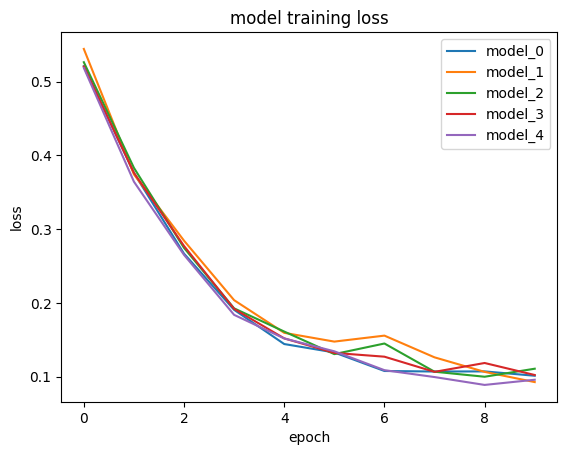

In [11]:
plt.title('model training loss')
plt.ylabel('loss')
plt.xlabel('epoch')
for key in history.keys():
    plt.plot(history[key].history['loss'], label="model_{}".format(key))
plt.legend()

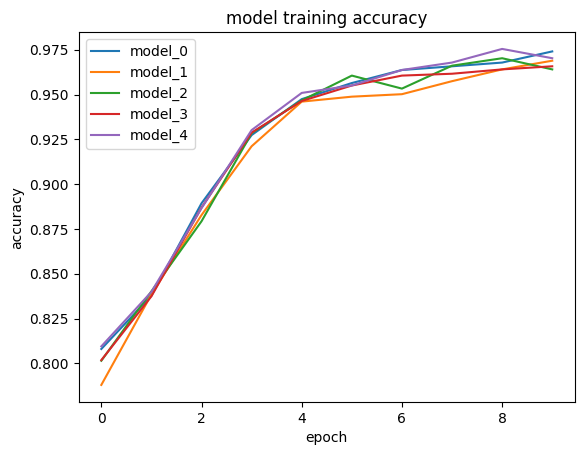

In [12]:
plt.title('model training accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
for key in history.keys():
    plt.plot(history[key].history['accuracy'], label="model_{}".format(key))
plt.legend()

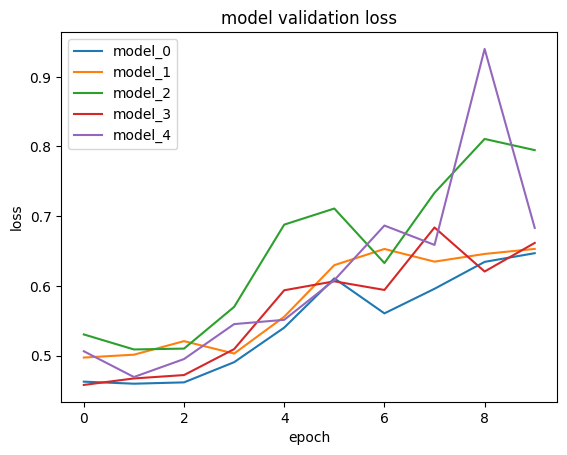

In [13]:
plt.title('model validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
for key in history.keys():
    plt.plot(history[key].history['val_loss'], label="model_{}".format(key))
plt.legend()

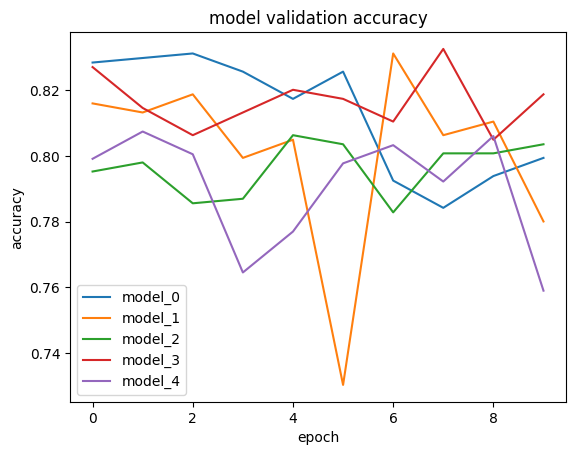

In [14]:
plt.title('model validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
for key in history.keys():
    plt.plot(history[key].history['val_accuracy'], label="model_{}".format(key))
plt.legend()

In [15]:
print("Loss: {}, Accuracy: {}, Precision: {}, Recall: {}, F1 Score: {}".format(
    np.average(loss), np.average(accuracy), np.average(precision), np.average(recall), np.average(F1)
))

Loss: 0.6686907529830932, Accuracy: 0.8046460032463074, Precision: 0.8521148324012756, Recall: 0.9223719596862793, F1 Score: 0.8854589869817499


In [16]:
best_model.save("CNN_FNC")

INFO:tensorflow:Assets written to: CNN_FNC\assets
